# Fianl Project - Hongyu Wang

## 1 Data Exploration

### 1.1 Load Data

In [1]:
import numpy as np
import pandas as pd
import os

wd = os.getcwd()
path = os.path.join(wd, "UTKFace")
files = os.listdir(path)
size = len(files)
print("Total sample size is", size)

Total sample size is 23708


In [231]:
# create three lists to store information of age, gender, race, and image respectively
import cv2
ages = []
genders = []
races = []
images = []

for file in files:
    try:
        age = int(file.split('_')[0]) # string to int
        gender = int(file.split('_')[1]) # string to int
        race = int(file.split('_')[2])

        img = cv2.imread(path+'/'+file) # Using 0 to read image in grayscale mode
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dim = (96, 96)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) # resize the original image to 60 * 60 * 3

        ages.append(age)
        genders.append(gender)
        races.append(race)
        images.append(img)
    except Exception as ex:
        continue

### 1.2 Data Visualization

#### 1.2.1 Gender 

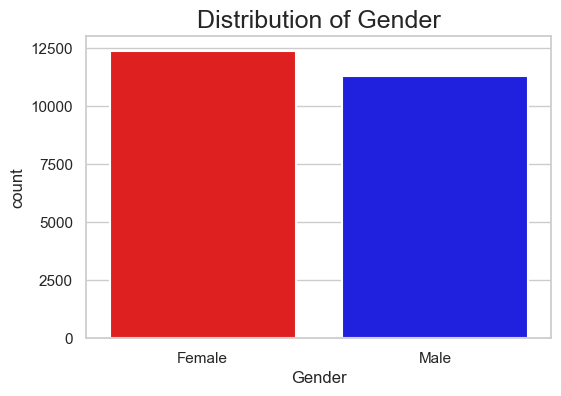

In [174]:
# visualize gender distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame({"Gender": genders, "Age": ages})

fig, ax = plt.subplots()
sns.set_context("talk")
sns.set_palette(["red", "blue"])
sns.countplot(x = "Gender", data = df, order = [0,1])
ax.set_xticklabels(["Female", "Male"])
ax.set_title("Distribution of Gender")
plt.show()
fig.savefig('gender_distribution.png', dpi = 300, bbox_inches='tight')

We can see that the distribution of gender is relatively balanced, with a little bit more of female.

#### 1.2.2 Age

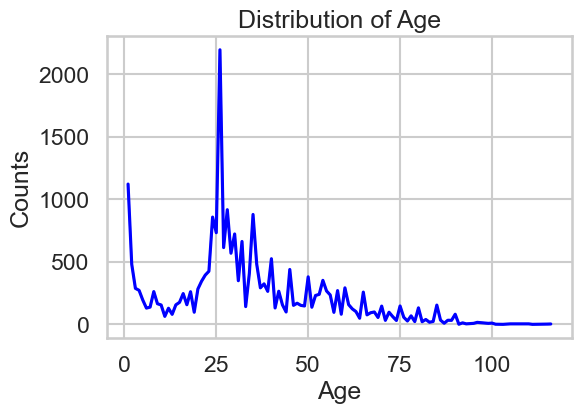

In [175]:
# visualize age distribution
df['Counts'] = df.groupby(['Age'])['Age'].transform('count')

fig, ax = plt.subplots()
sns.set_context("talk")
sns.lineplot(x = "Age",y = "Counts", data = df, color = "blue")
ax.set_title("Distribution of Age")
plt.show()
fig.savefig('age_distribution.png', dpi = 300, bbox_inches='tight')

We can see that most of the samples are below age 50, and thus we may get skewed training dataset. I will try to solve this problem during data preprocessing.

#### 1.2.3 Race

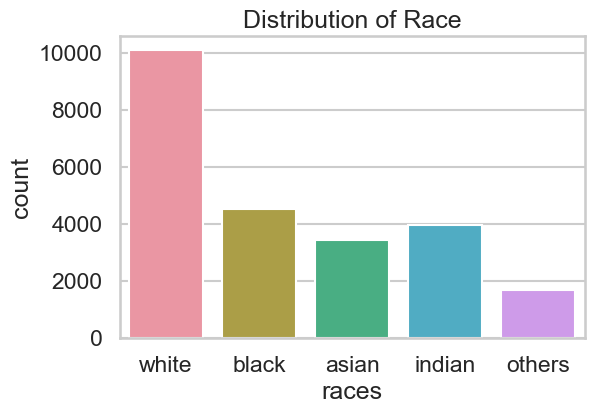

In [176]:
temp = pd.DataFrame({"races":races})
g = sns.countplot(x = "races", data = temp)
g.set_title("Distribution of Race")
g.set_xticklabels(["white", "black", "asian", "indian", "others"])
plt.show()
g.figure.savefig('race_distribution.png', dpi = 300, bbox_inches='tight')

#### 1.2.4 Image

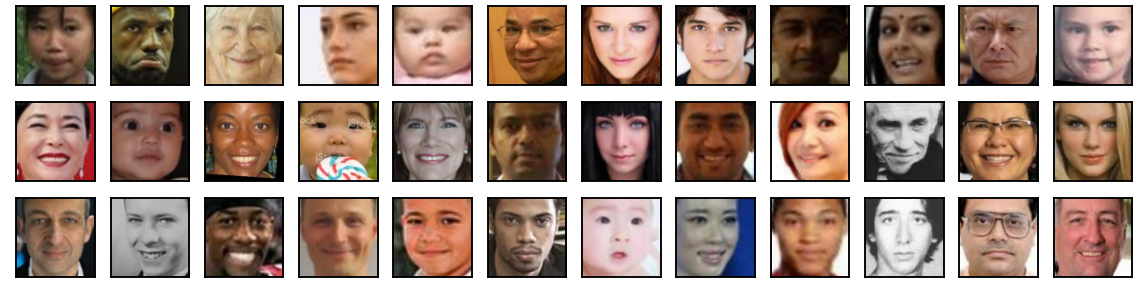

In [12]:
def visualize_data():
    images_to_show = 36
    per_row = 12
    fig = plt.figure(figsize=(20,5))
    for i in range(images_to_show):
        pos = (i // per_row, i % per_row)
        ax = plt.subplot2grid((int(images_to_show / per_row), per_row),
                              pos, xticks=[], yticks=[])
        ax.imshow(images[i])
    plt.show()
    fig.savefig('face_demo.png', dpi = 300, bbox_inches='tight')
    
visualize_data()

## 2 Data Preprocessing

### 2.1 One Hot Encode

#### 2.1.1 Age

I divide ages into 8 age groups:
- class1: 0 <= age < 6
- class2: 6 <= age < 12
- class3: 12 <= age < 25
- class4: 25 <= age < 35
- class5: 35 <= age < 45
- class6: 45 <= age < 60
- class7: 60 <= age < 80
- class8: age >= 80

In [232]:
def age_group(age):
    if age >=0 and age < 6:
        return "class1"
    elif age < 12:
        return "class2"
    elif age < 25:
        return "class3"
    elif age < 35:
        return "class4"
    elif age < 45:
        return "class5"
    elif age < 60:
        return "class6"
    elif age < 80:
        return "class7"
    else:
        return "class8"

for i in range(len(ages)):
    temp = ages[i]
    ages[i] = age_group(temp)
    
# The number of age categories
n_age_categories = 8
# The unique values of categories in the data
age_categories = np.array(["class1", "class2", "class3", "class4", "class5", "class6", "class7", "class8"])
# initialize ohe_labels as all zeros
age_ohe_labels = np.zeros((len(ages), n_age_categories))
# loope over the labels
for i in range(len(ages)):
    age_ohe_labels[i] = np.where(age_categories == ages[i], 1, 0)

#### 2.1.2 Gender

According to the dataset description:
- 0: male
- 1: female

In [233]:
def gender_group(gender):
    if gender == 0:
        return "male"
    else:
        return "female"
    
for i in range(len(genders)):
    temp = genders[i]
    genders[i] = gender_group(temp)

n_gender_categories = 2
gender_categories = np.array(["male", "female"])
gender_ohe_labels = np.zeros((len(genders), n_gender_categories))
for i in range(len(genders)):
    gender_ohe_labels[i] = np.where(gender_categories == genders[i], 1, 0)

#### 2.1.3 Race

According to the decription of the dataset:
- 0: white
- 1: black
- 2: asian
- 3: indian
- 4: others

In [234]:
def race_group(race):
    if race == 0:
        return "white"
    elif race == 1:
        return "black"
    elif race == 2:
        return "asian"
    elif race == 3:
        return "indian"
    else:
        return "others"
    
for i in range(len(races)):
    temp = races[i]
    races[i] = race_group(temp)
    
n_race_categories = 5
race_categories = np.array(["white", "black", "asian", "indian", "others"])
race_ohe_labels = np.zeros((len(races), n_race_categories))
for i in range(len(races)):
    race_ohe_labels[i] = np.where(race_categories == races[i], 1, 0)

### 2.2 Prepare Training, Validation, and Test Sets

In [32]:


img_features = np.array(images)
img_features = img_features / 255 # normalize images


n1 = int(len(img_features) * 0.75)
n2 = int((len(img_features) - n1) / 4) + n1
# training set
x_train, y_train = img_features[:n1], [age_ohe_labels[:n1], gender_ohe_labels[:n1], race_ohe_labels[:n1]]
# test set
x_test, y_test = img_features[n1:n2], [age_ohe_labels[n1:n2], gender_ohe_labels[n1:n2], race_ohe_labels[n1:n2]]
# valid set
x_valid, y_valid = img_features[n2:], [age_ohe_labels[n2:], gender_ohe_labels[n2:], race_ohe_labels[n2:]]


### 2.3 Data Augmentation

#### 2.3.1 Data Augmentation Generator

In [33]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
            width_shift_range=.15,
            height_shift_range=.15,
            rotation_range=15,
            horizontal_flip=True,
            zoom_range=[0.5,1.0])


#### 2.3.2 Image Data Augmentation Result Example

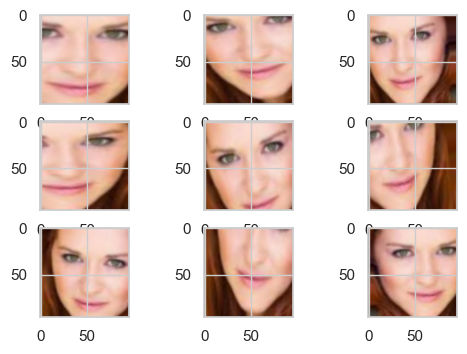

<Figure size 600x400 with 0 Axes>

In [143]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def plot_augmentation(image):
    data = img_to_array(image)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    image_gen = ImageDataGenerator(
            width_shift_range=.15,
            height_shift_range=.15,
            rotation_range=15,
            horizontal_flip=True,
            zoom_range=[0.5,1.0])
    # prepare iterator
    it = image_gen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        plt.imshow(image)
    # show the figure
    plt.show()
    plt.savefig('augmentation_demo.png', dpi = 300, bbox_inches='tight')
    
    
plot_augmentation(images[6])


#### 2.3.3 Data Augmentation Generator for Model Training

In [53]:
batch_size = 32
def generator(x_train, y_train):
    genX1 = image_gen.flow(x_train,y_train[0], batch_size=batch_size,seed=1)
    genX2 = image_gen.flow(x_train,y_train[1], batch_size=batch_size,seed=1)
    genX3 = image_gen.flow(x_train,y_train[2], batch_size=batch_size,seed=1)
    
    while True:
            X1 = genX1.next()
            X2 = genX2.next()
            X3 = genX3.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            X = X1[0]/255.0
            yield X, [X1[1], X2[1], X3[1]]
            
images_temp = np.array(images)
x_train_temp, y_train_temp = images_temp[:n1], [age_ohe_labels[:n1], gender_ohe_labels[:n1], race_ohe_labels[:n1]]
# create generator
gen_flow = generator(x_train_temp, [y_train_temp[0], y_train_temp[1], y_train_temp[2]])

## 3 Model Building & Training

### 3.1 Hyperparameter Tuning

#### 3.1.1 Optimizer

In [180]:
def get_alexnet_model(optimizer):
    np.random.seed(1000)
    inputs = Input(shape = (96, 96, 3))

    # 1st Convolutional Layer
    conv1 = Conv2D(filters=96, kernel_size=(2,2), strides=(2,2), padding="valid", activation = "relu")(inputs)
    # Max Pooling
    maxp1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv1)
    maxp1 = BatchNormalization() (maxp1)

    # 2nd Convolutional Layer
    conv2 = Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), padding="same", activation = "relu") (maxp1)
    # Max Pooling
    maxp2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
    maxp2 = BatchNormalization() (maxp2)

    # 3rd Convolutional Layer
    conv3 = Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(maxp2)

    # 4th Convolutional Layer
    conv4 = Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(conv3)

    # 5th Convolutional Layer
    conv5 = Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(conv4)
    # Max Pooling
    maxp3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv5)

    # Passing it to a Fully Connected layer
    flatten = Flatten()(maxp3)


    # 1st Fully Connected Layer
    dense_1 = Dense(1024, activation = 'relu') (flatten)
    dense_1 = BatchNormalization() (dense_1)
    dense_2 = Dense(1024, activation = 'relu') (flatten)
    dense_2 = BatchNormalization() (dense_2)
    dense_3 = Dense(1024, activation = 'relu') (flatten)
    dense_3 = BatchNormalization() (dense_3)

    drop_1 = Dropout(0.4) (dense_1)
    drop_2 = Dropout(0.4) (dense_2)
    drop_3 = Dropout(0.4) (dense_3)

    # 2nd Fully Connected Layer
    dense_1 = Dense(1024, activation = 'relu') (flatten)
    dense_1 = BatchNormalization() (dense_1)
    dense_2 = Dense(1024, activation = 'relu') (flatten)
    dense_2 = BatchNormalization() (dense_2)
    dense_3 = Dense(1024, activation = 'relu') (flatten)
    dense_3 = BatchNormalization() (dense_3)

    drop_1 = Dropout(0.4) (dense_1)
    drop_2 = Dropout(0.4) (dense_2)
    drop_3 = Dropout(0.4) (dense_3)

    # 3rd Fully Connected Layer
    dense_1 = Dense(1024, activation = 'relu') (flatten)
    dense_1 = BatchNormalization() (dense_1)
    dense_2 = Dense(1024, activation = 'relu') (flatten)
    dense_2 = BatchNormalization() (dense_2)
    dense_3 = Dense(1024, activation = 'relu') (flatten)
    dense_3 = BatchNormalization() (dense_3)

    drop_1 = Dropout(0.4) (dense_1)
    drop_2 = Dropout(0.4) (dense_2)
    drop_3 = Dropout(0.4) (dense_3)

    output_1 = Dense(n_age_categories, activation = "softmax", name = "age_out") (drop_1)
    output_2 = Dense(n_gender_categories, activation = "sigmoid", name = "gender_out") (drop_2)
    output_3 = Dense(n_race_categories, activation = "softmax", name = "race_out") (drop_3)

    model = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])
    
    model.compile(loss = {"gender_out":"binary_crossentropy", 
                                       "age_out":"categorical_crossentropy",
                                        "race_out":"categorical_crossentropy"}, 
                               optimizer = optimizer, 
                               metrics = ["accuracy"])
    
    return model




In [189]:
from keras.optimizers import Adam, SGD, RMSprop, Adamax

# optimizers
adam = Adam()
sgd = SGD()
rmsprop = RMSprop()
adamax = Adamax()

optimizers = [sgd, rmsprop, adamax]

optimizer_results = {}
for optimizer in optimizers:
    model = get_alexnet_model(optimizer = optimizer)
    history = model.fit_generator(gen_flow,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=50,
                        validation_data=(x_valid, y_valid))
    optimizer_results[str(optimizer)] = history


Epoch 1/50
555/555 [==============================] - 217s 391ms/step - loss: 4.3879 - age_out_loss: 2.1458 - gender_out_loss: 0.6771 - race_out_loss: 1.5650 - age_out_accuracy: 0.2495 - gender_out_accuracy: 0.6590 - race_out_accuracy: 0.4153 - val_loss: 3.5145 - val_age_out_loss: 1.6940 - val_gender_out_loss: 0.5548 - val_race_out_loss: 1.2657 - val_age_out_accuracy: 0.3554 - val_gender_out_accuracy: 0.7267 - val_race_out_accuracy: 0.4984
Epoch 2/50
555/555 [==============================] - 202s 363ms/step - loss: 3.6549 - age_out_loss: 1.7815 - gender_out_loss: 0.5705 - race_out_loss: 1.3028 - age_out_accuracy: 0.3285 - gender_out_accuracy: 0.7188 - race_out_accuracy: 0.5016 - val_loss: 3.3480 - val_age_out_loss: 1.6611 - val_gender_out_loss: 0.4798 - val_race_out_loss: 1.2070 - val_age_out_accuracy: 0.3201 - val_gender_out_accuracy: 0.7701 - val_race_out_accuracy: 0.5376
Epoch 3/50
555/555 [==============================] - 207s 372ms/step - loss: 3.4079 - age_out_loss: 1.6587 - ge

In [190]:
optimizer_results.items()

dict_items([('adam', <tensorflow.python.keras.callbacks.History object at 0x7f772ece0760>), ('<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f772ecead90>', <tensorflow.python.keras.callbacks.History object at 0x7f77a78c0b80>), ('<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f772ecead30>', <tensorflow.python.keras.callbacks.History object at 0x7f77ac3d23d0>), ('<tensorflow.python.keras.optimizer_v2.adamax.Adamax object at 0x7f772ecea640>', <tensorflow.python.keras.callbacks.History object at 0x7f77b1a74b20>)])

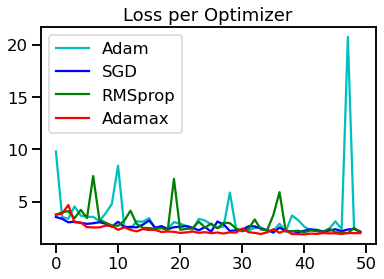

In [219]:
import pandas as pd

# extract val_loss history of each optimizer
val_loss_per_optimizer = {k: v.history["val_loss"] for k, v in optimizer_results.items()}

# turn the dictionary into a pandas dataframe
val_loss_curves = pd.DataFrame(val_loss_per_optimizer)
val_loss_curves.columns = ["Adam", "SGD", "RMSprop", "Adamax"]

# plot the result
ax = val_loss_curves.plot(title = "Loss per Optimizer", color = ["c", "b", "g", "r"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

#### 3.1.1 Number of Filter, Dropout Rate, Learning Rate, and Decay Rate

In [241]:
from kerastuner import HyperModel


class MyHyperModel(HyperModel):
    def build(self, hp):
        inputs = Input(shape = (96, 96, 3))

        # 1st Convolutional Layer
        conv1 = Conv2D(filters=hp.Choice(
                    'num_filter_conv1',
                    values=[64, 96, 128],
                    default=96,
                ), kernel_size=(2,2), strides=(2,2), padding="valid", activation = "relu")(inputs)
        
        # Max Pooling
        maxp1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv1)
        maxp1 = BatchNormalization() (maxp1)

        # 2nd Convolutional Layer
        conv2 = Conv2D(filters=hp.Choice(
                    'num_filter_conv2',
                    values=[96, 128, 256],
                    default=256,
                ), kernel_size=(2,2), strides=(1,1), padding="same", activation = "relu") (maxp1)
        # Max Pooling
        maxp2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
        maxp2 = BatchNormalization() (maxp2)

        # 3rd Convolutional Layer
        conv3 = Conv2D(filters=hp.Choice(
                    'num_filter_conv3',
                    values=[96, 256, 384],
                    default=384,
                ), kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(maxp2)

        # 4th Convolutional Layer
        conv4 = Conv2D(filters=hp.Choice(
                    'num_filter_conv4',
                    values=[96, 256, 384],
                    default=384,
                ), kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(conv3)

        # 5th Convolutional Layer
        conv5 = Conv2D(filters=hp.Choice(
                    'num_filter_conv5',
                    values=[96, 128, 256],
                    default=256
                ), kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(conv4)
        # Max Pooling
        maxp3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv5)

        # Passing it to a Fully Connected layer
        flatten = Flatten()(maxp3)


        # 1st Fully Connected Layer
        dense_1 = Dense(1024, activation = 'relu') (flatten)
        dense_1 = BatchNormalization() (dense_1)
        dense_2 = Dense(1024, activation = 'relu') (flatten)
        dense_2 = BatchNormalization() (dense_2)
        dense_3 = Dense(1024, activation = 'relu') (flatten)
        dense_3 = BatchNormalization() (dense_3)

        drop_1 = Dropout(rate=hp.Float(
                'dropout_1_1',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_1)
        drop_2 = Dropout(rate=hp.Float(
                'dropout_1_2',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_2)
        drop_3 = Dropout(rate=hp.Float(
                'dropout_1_3',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_3)

        # 2nd Fully Connected Layer
        dense_1 = Dense(1024, activation = 'relu') (flatten)
        dense_1 = BatchNormalization() (dense_1)
        dense_2 = Dense(1024, activation = 'relu') (flatten)
        dense_2 = BatchNormalization() (dense_2)
        dense_3 = Dense(1024, activation = 'relu') (flatten)
        dense_3 = BatchNormalization() (dense_3)

        drop_1 = Dropout(rate=hp.Float(
                'dropout_2_1',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_1)
        drop_2 = Dropout(rate=hp.Float(
                'dropout_2_2',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_2)
        drop_3 = Dropout(rate=hp.Float(
                'dropout_2_3',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_3)

        # 3rd Fully Connected Layer
        dense_1 = Dense(1024, activation = 'relu') (flatten)
        dense_1 = BatchNormalization() (dense_1)
        dense_2 = Dense(1024, activation = 'relu') (flatten)
        dense_2 = BatchNormalization() (dense_2)
        dense_3 = Dense(1024, activation = 'relu') (flatten)
        dense_3 = BatchNormalization() (dense_3)

        drop_1 = Dropout(rate=hp.Float(
                'dropout_3_1',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_1)
        drop_2 = Dropout(rate=hp.Float(
                'dropout_3_2',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_2)
        drop_3 = Dropout(rate=hp.Float(
                'dropout_3_3',
                min_value=0.2,
                max_value=0.5,
                default=0.4,
                step=0.05)) (dense_3)

        output_1 = Dense(n_age_categories, activation = "softmax", name = "age_out") (drop_1)
        output_2 = Dense(n_gender_categories, activation = "sigmoid", name = "gender_out") (drop_2)
        output_3 = Dense(n_race_categories, activation = "softmax", name = "race_out") (drop_3)

        model = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])

        # optimizer
        adamax = Adamax(lr = hp.Float(
                    'learning_rate',
                    min_value=1e-6,
                    max_value=1e-3,
                    sampling='LOG',
                    default=1e-4
                ), decay = hp.Float(
                    'decay',
                    min_value=1e-7,
                    max_value=1e-4,
                    sampling='LOG',
                    default=1e-6
                ))
        model.compile(loss = {"gender_out":"binary_crossentropy", 
                                               "age_out":"categorical_crossentropy",
                                                "race_out":"categorical_crossentropy"}, 
                                       optimizer = adamax, 
                                       metrics = ["accuracy"])
                         
        return model



In [401]:
from kerastuner.tuners import Hyperband

hypermodel = MyHyperModel()

max_epochs = 40
executions_per_trial = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=max_epochs,
    
    ,
    seed=767,
    executions_per_trial=executions_per_trial,
    directory='hyperband',
    project_name='767 project tuning'
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project hyperband/767 project tuning/oracle.json
Search space summary
Default search space size: 16
num_filter_conv1 (Choice)
{'default': 96, 'conditions': [], 'values': [64, 96, 128], 'ordered': True}
num_filter_conv2 (Choice)
{'default': 256, 'conditions': [], 'values': [96, 128, 256], 'ordered': True}
num_filter_conv3 (Choice)
{'default': 384, 'conditions': [], 'values': [96, 256, 384], 'ordered': True}
num_filter_conv4 (Choice)
{'default': 384, 'conditions': [], 'values': [96, 256, 384], 'ordered': True}
num_filter_conv5 (Choice)
{'default': 256, 'conditions': [], 'values': [96, 128, 256], 'ordered': True}
dropout_1_1 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_1_2 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_1_3 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5

In [ ]:
N_EPOCH_SEARCH = 50

tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.1)

Trial 74 Complete [01h 13m 36s]
val_loss: 2.3290430307388306

Best val_loss So Far: 2.216052532196045
Total elapsed time: 17h 24m 14s

Search: Running Trial #75

Hyperparameter    |Value             |Best Value So Far 
num_filter_conv1  |128               |96                
num_filter_conv2  |96                |128               
num_filter_conv3  |384               |96                
num_filter_conv4  |256               |256               
num_filter_conv5  |128               |128               
dropout_1_1       |0.3               |0.5               
dropout_1_2       |0.2               |0.2               
dropout_1_3       |0.45              |0.35              
dropout_2_1       |0.45              |0.25              
dropout_2_2       |0.5               |0.3               
dropout_2_3       |0.45              |0.25              
dropout_3_1       |0.3               |0.35              
dropout_3_2       |0.45              |0.4               
dropout_3_3       |0.25              |0.

In [233]:
# tuner.search(gen_flow,steps_per_epoch=x_train.shape[0] // batch_size,epochs=N_EPOCH_SEARCH,validation_data=(x_valid, y_valid))

### 3.2 Modle Building

#### 3.2.1 Model 1

Model 1 has 5 convolutional layers, and 3 fully connectect layers for each output.

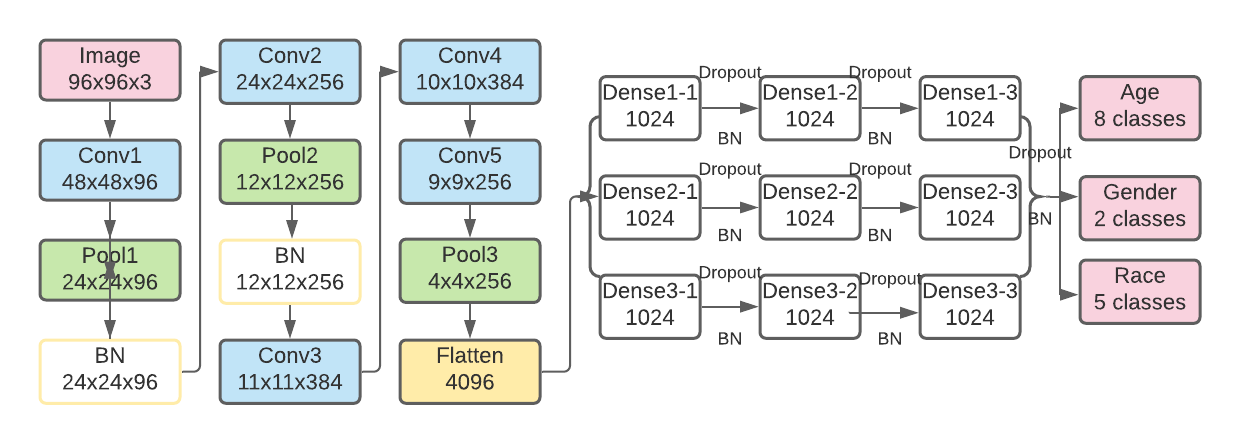

In [6]:
from IPython.display import Image
Image(filename = "model1.png")

In [57]:
import keras
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model
from keras.optimizers import Adamax
import numpy as np
np.random.seed(1000)
inputs = Input(shape = (96, 96, 3))

# 1st Convolutional Layer
conv1 = Conv2D(filters=96, kernel_size=(2,2), strides=(2,2), padding="valid", activation = "relu")(inputs)
# Max Pooling
maxp1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv1)
maxp1 = BatchNormalization() (maxp1)

# 2nd Convolutional Layer
conv2 = Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding="same", activation = "relu") (maxp1)
# Max Pooling
maxp2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
maxp2 = BatchNormalization() (maxp2)

# 3rd Convolutional Layer
conv3 = Conv2D(filters=96, kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(maxp2)

# 4th Convolutional Layer
conv4 = Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(conv3)

# 5th Convolutional Layer
conv5 = Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding="valid", activation = "relu")(conv4)
# Max Pooling
maxp3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv5)

# Passing it to a Fully Connected layer
flatten = Flatten()(maxp3)


# 1st Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.5) (dense_1)
drop_2 = Dropout(0.2) (dense_2)
drop_3 = Dropout(0.35) (dense_3)

# 2nd Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.25) (dense_1)
drop_2 = Dropout(0.3) (dense_2)
drop_3 = Dropout(0.25) (dense_3)

# 3rd Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.35) (dense_1)
drop_2 = Dropout(0.4) (dense_2)
drop_3 = Dropout(0.25) (dense_3)

output_1 = Dense(n_age_categories, activation = "softmax", name = "age_out") (drop_1)
output_2 = Dense(n_gender_categories, activation = "sigmoid", name = "gender_out") (drop_2)
output_3 = Dense(n_race_categories, activation = "softmax", name = "race_out") (drop_3)

model = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])

# optimizer
adam = Adamax(lr = 0.00088483, decay = 1.096e-07)
model.compile(loss = {"gender_out":"binary_crossentropy", 
                                       "age_out":"categorical_crossentropy",
                                        "race_out":"categorical_crossentropy"}, 
                               optimizer = adam, 
                               metrics = ["accuracy"])

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 48, 48, 96)   1248        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 24, 24, 96)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 24, 24, 96)   384         max_pooling2d_9[0][0]            
_______________________________________________________________________________________

In [59]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpointer = ModelCheckpoint("best_model1.h5", monitor='val_loss',verbose=1,save_best_only=True)
early_stop= EarlyStopping(patience=50, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,early_stop]

history1 = model.fit_generator(gen_flow,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=100,
                        validation_data=(x_valid, y_valid),
                        callbacks = callback_list)

Epoch 1/100
555/555 [==============================] - ETA: 0s - loss: 3.9457 - age_out_loss: 1.9232 - gender_out_loss: 0.6379 - race_out_loss: 1.3846 - age_out_accuracy: 0.3031 - gender_out_accuracy: 0.6874 - race_out_accuracy: 0.4701
Epoch 00001: val_loss improved from inf to 3.32800, saving model to best_model1.h5
555/555 [==============================] - 156s 281ms/step - loss: 3.9457 - age_out_loss: 1.9232 - gender_out_loss: 0.6379 - race_out_loss: 1.3846 - age_out_accuracy: 0.3031 - gender_out_accuracy: 0.6874 - race_out_accuracy: 0.4701 - val_loss: 3.3280 - val_age_out_loss: 1.6486 - val_gender_out_loss: 0.5179 - val_race_out_loss: 1.1615 - val_age_out_accuracy: 0.3734 - val_gender_out_accuracy: 0.7393 - val_race_out_accuracy: 0.5497
Epoch 2/100
555/555 [==============================] - ETA: 0s - loss: 3.5388 - age_out_loss: 1.7310 - gender_out_loss: 0.5668 - race_out_loss: 1.2410 - age_out_accuracy: 0.3460 - gender_out_accuracy: 0.7288 - race_out_accuracy: 0.5344
Epoch 00002:

#### 3.2.2 Model 2 (Adding more convolutional layers)

Model2 has 10 convolutional layers, and 3 fully connectect layers for each output.

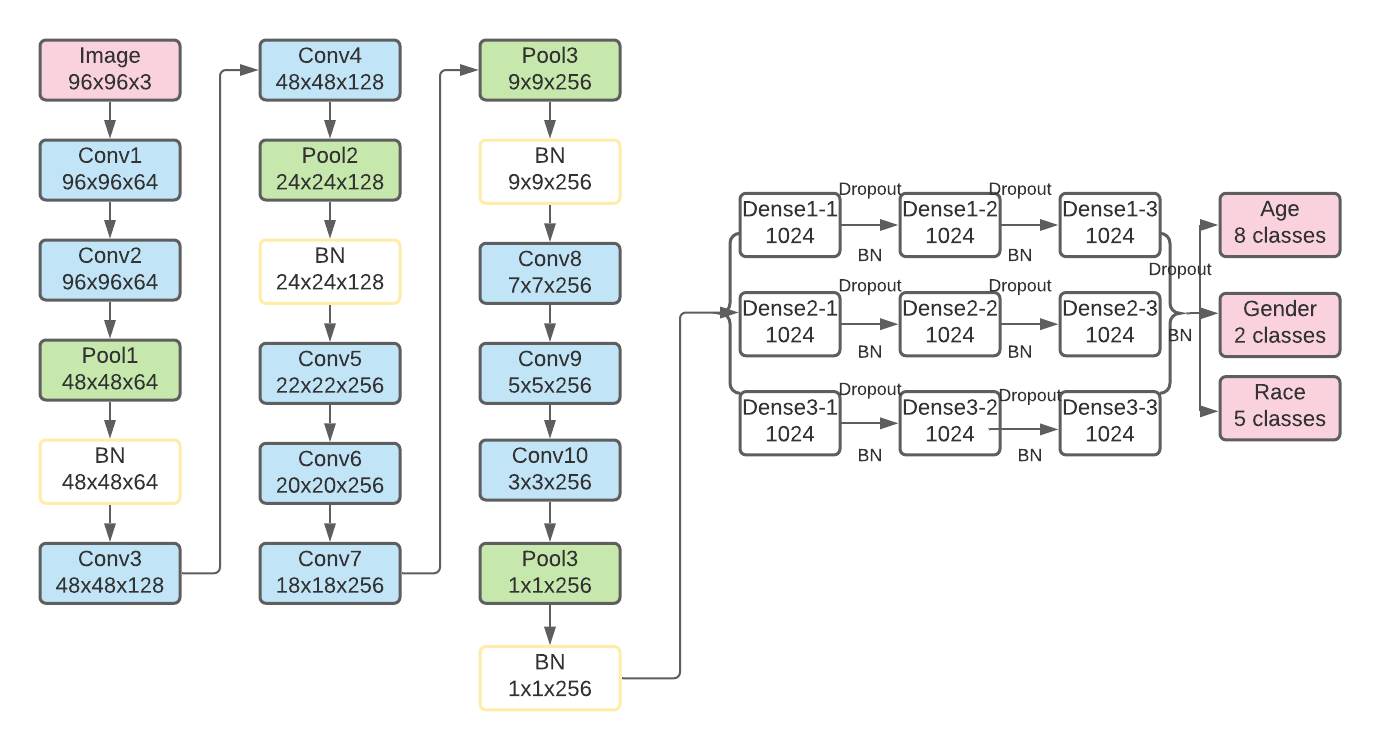

In [7]:
Image(filename = "model2.png")

In [177]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
np.random.seed(1000)

inputs = Input(shape = (96, 96, 3))


conv1 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation = "relu")(inputs)
conv2 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation = "relu")(conv1)
# Max Pooling
maxp1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
maxp1 = BatchNormalization()(maxp1)

conv3 = Conv2D(filters=128, kernel_size=(3,3),  padding="same", activation = "relu")(maxp1)
conv4 = Conv2D(filters=128, kernel_size=(3,3),  padding="same", activation = "relu")(conv3)
# Max Pooling
maxp2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv4)
maxp2 = BatchNormalization()(maxp2)

conv5 = Conv2D(filters=256, kernel_size=(3,3), padding="valid", activation = "relu") (maxp2)
conv6 = Conv2D(filters=256, kernel_size=(3,3), padding="valid", activation = "relu") (conv5)
conv7 = Conv2D(filters=256, kernel_size=(3,3), padding="valid", activation = "relu") (conv6)
# Max Pooling
maxp3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv7)
maxp3 = BatchNormalization()(maxp3)

conv8 = Conv2D(filters=256, kernel_size=(3,3), padding="valid", activation = "relu") (maxp3)
conv9 = Conv2D(filters=256, kernel_size=(3,3), padding="valid", activation = "relu") (conv8)
conv10 = Conv2D(filters=256, kernel_size=(3,3), padding="valid", activation = "relu") (conv9)
# Max Pooling
maxp4 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv10)
maxp4 = BatchNormalization()(maxp4)


# Passing it to a Fully Connected layer
flatten = Flatten()(maxp4)

# 1st Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.5) (dense_1)
drop_2 = Dropout(0.2) (dense_2)
drop_3 = Dropout(0.35) (dense_3)

# 2nd Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.25) (dense_1)
drop_2 = Dropout(0.3) (dense_2)
drop_3 = Dropout(0.25) (dense_3)

# 3rd Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.35) (dense_1)
drop_2 = Dropout(0.4) (dense_2)
drop_3 = Dropout(0.25) (dense_3)

output_1 = Dense(n_age_categories, activation = "softmax", name = "age_out") (drop_1)
output_2 = Dense(n_gender_categories, activation = "sigmoid", name = "gender_out") (drop_2)
output_3 = Dense(n_race_categories, activation = "softmax", name = "race_out") (drop_3)

model2 = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])

# optimizer
adam = Adamax(lr = 0.00088483, decay = 1.096e-07)
model2.compile(loss = {"gender_out":"binary_crossentropy", 
                                       "age_out":"categorical_crossentropy",
                                        "race_out":"categorical_crossentropy"}, 
                               optimizer = adam, 
                               metrics = ["accuracy"])

model2.summary()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 96, 96, 64)   1792        input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 96, 96, 64)   36928       conv2d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_59 (MaxPooling2D) (None, 48, 48, 64)   0           conv2d_34[0][0]                  
______________________________________________________________________________________

In [178]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpointer = ModelCheckpoint("best_model3.h5", monitor='val_loss',verbose=1,save_best_only=True)
early_stop= EarlyStopping(patience=50, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,early_stop]

history2 = model2.fit_generator(gen_flow,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=100,
                        validation_data=(x_valid, y_valid),
                        callbacks = callback_list)

Epoch 1/100
555/555 [==============================] - ETA: 0s - loss: 4.6212 - age_out_loss: 2.2598 - gender_out_loss: 0.7648 - race_out_loss: 1.5966 - age_out_accuracy: 0.2304 - gender_out_accuracy: 0.5946 - race_out_accuracy: 0.4003
Epoch 00001: val_loss improved from inf to 3.95345, saving model to best_model3.h5
555/555 [==============================] - 949s 2s/step - loss: 4.6212 - age_out_loss: 2.2598 - gender_out_loss: 0.7648 - race_out_loss: 1.5966 - age_out_accuracy: 0.2304 - gender_out_accuracy: 0.5946 - race_out_accuracy: 0.4003 - val_loss: 3.9534 - val_age_out_loss: 1.8541 - val_gender_out_loss: 0.6605 - val_race_out_loss: 1.4388 - val_age_out_accuracy: 0.2960 - val_gender_out_accuracy: 0.5929 - val_race_out_accuracy: 0.4665
Epoch 2/100
555/555 [==============================] - ETA: 0s - loss: 4.0881 - age_out_loss: 1.9612 - gender_out_loss: 0.6799 - race_out_loss: 1.4470 - age_out_accuracy: 0.3029 - gender_out_accuracy: 0.6537 - race_out_accuracy: 0.4559
Epoch 00002: va

#### 3.2.3 Model 3 (Adding more convolutional layers with residual learning)

Model2 has 16 convolutional layers with residual learning, and 3 fully connectect layers for each output.

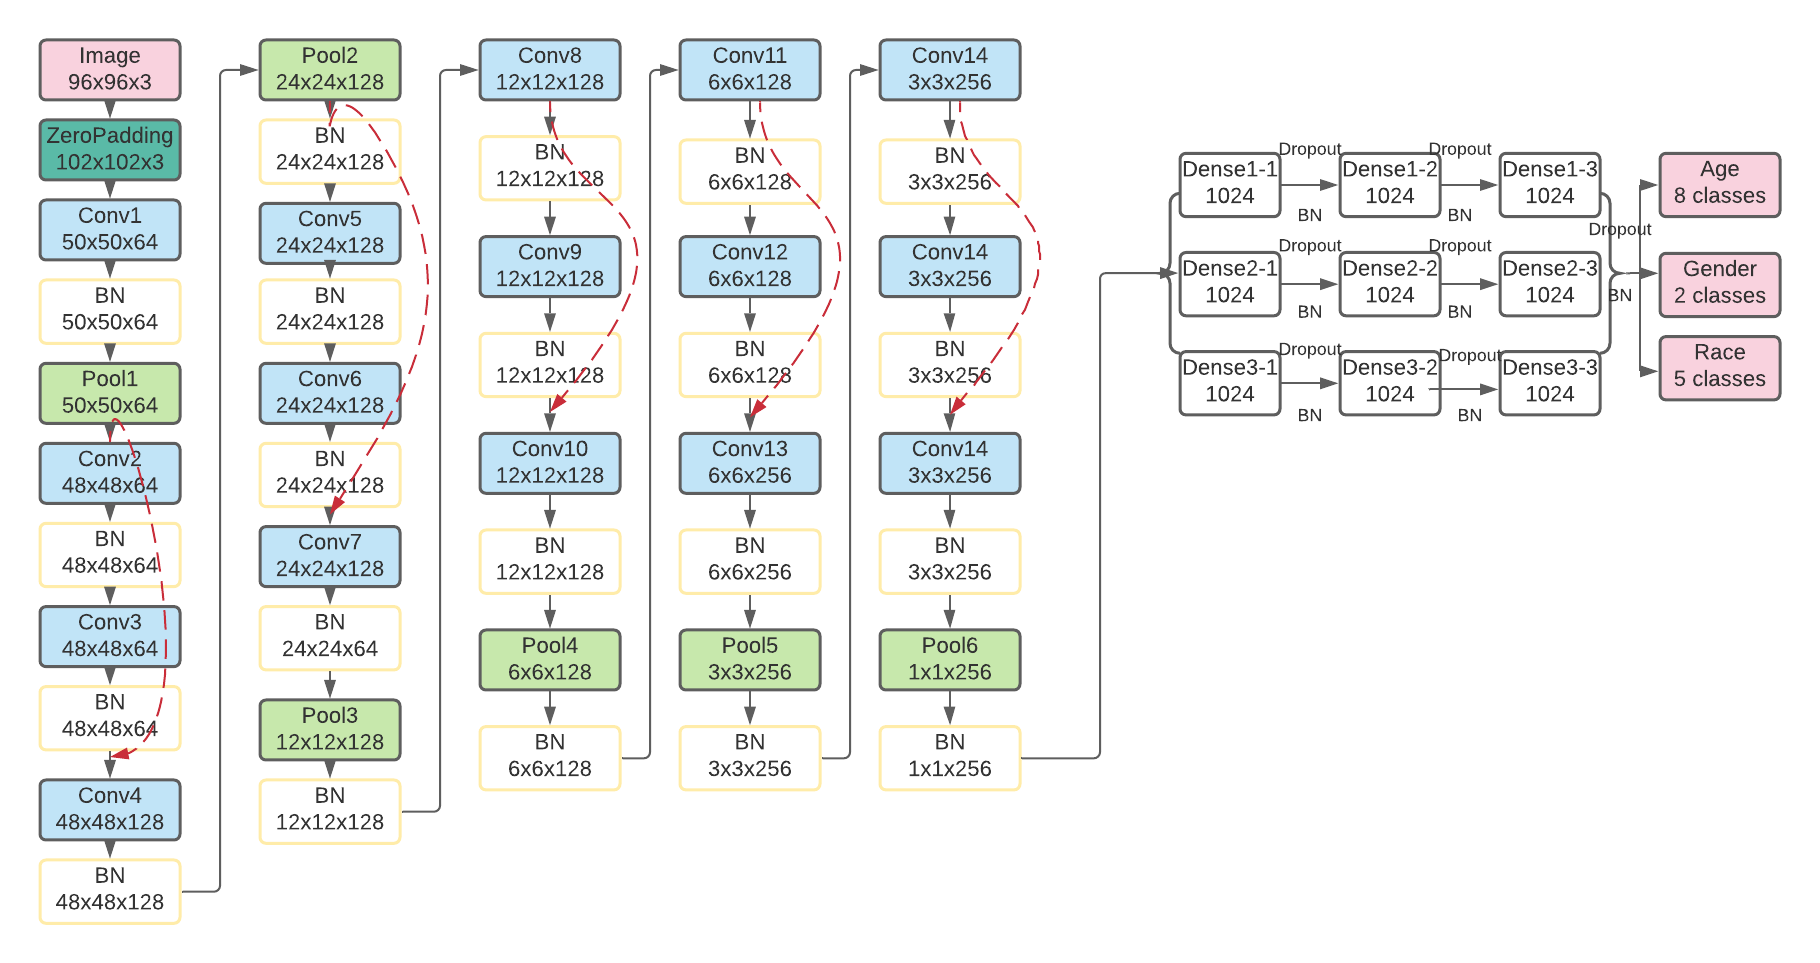

In [4]:
Image(filename = "model3.png")

In [192]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
np.random.seed(1000)
from keras.layers import Add, Dense, Activation, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

# standard block - when input sha4pe and output shape are the same
def identity_block(x, filters, stage, block):
    conv_layer_name = "convstage%dblock%d"%(stage, block)
    bn_layer_name = "bnstate%dblock%d"%(stage, block)
    
    filter1, filter2 = filters
    
    x_shortcut = x
    
    # fist component
    x = Conv2D(filters = filter1, kernel_size = (1,1),  kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "-A")(x)
    x = BatchNormalization(axis = 3, name = bn_layer_name + "A")(x)
    x = Activation("relu")(x)
    
    # second component
    x = Conv2D(filters = filter1, kernel_size = (3,3), padding = "same", kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "-B")(x)
    x = BatchNormalization(axis = 3, name = bn_layer_name + "B")(x)
    x = Activation("relu")(x)
    
    # third component
    x = Conv2D(filters = filter2, kernel_size = (1,1),  kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "-C")(x)
    x = BatchNormalization(axis = 3, name = bn_layer_name + "C")(x)
    
    x = Add()([x, x_shortcut])
    x = Activation("relu")(x)
    
    # Max Pooling
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(x)
    x = BatchNormalization()(x)
    
    return x

# this block is used when input shape and output shape are different
def convolutional_block(x, filters, stage, block):
    conv_layer_name = "convstage%dblock%d"%(stage, block)
    bn_layer_name = "bnstate%dblock%d"%(stage, block)
    
    filter1, filter2 = filters
    
    x_shortcut = x
    
    # fist component
    x = Conv2D(filters = filter1, kernel_size = (1,1), kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "-A")(x)
    x = BatchNormalization(axis = 3, name = bn_layer_name + "A")(x)
    x = Activation("relu")(x)
    
    # second component
    x = Conv2D(filters = filter1, kernel_size = (3,3), padding = "same", kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "-B")(x)
    x = BatchNormalization(axis = 3, name = bn_layer_name + "B")(x)
    
    # third component
    x = Conv2D(filters = filter2, kernel_size = (3,3), padding = "same", kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "-C")(x)
    x = BatchNormalization(axis = 3, name = bn_layer_name + "C")(x)
    
    # add a convolutional layer in the shortcut path
    x_shortcut = Conv2D(filters = filter2, kernel_size = (1,1), strides = (2,2), kernel_initializer = glorot_uniform(seed=0), name = conv_layer_name + "shortcut_path" + str(stage))(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3, name = bn_layer_name + "short_cutpath" + str(stage))(x)
    
    x = Add()([x, x_shortcut])
    x = Activation("relu")(x)
    
    # Max Pooling
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(x)
    x = BatchNormalization()(x)
    
    return x
    
    
# implementation
input_shape = (96, 96, 3)
inputs = Input(input_shape)

# zero-padding
x = ZeroPadding2D((3,3))(inputs)

# stage 1
x = Conv2D(64, kernel_size = (3,3), strides = (2,2), name = "convstage1")(x)
x = BatchNormalization(axis = 3, name = "bnstage1")(x)
x = Activation("relu")(x)
x = MaxPooling2D((3,3), strides = (1,1))(x)

# stage 2
x = convolutional_block(x, [64, 128], 2, 1)
x = identity_block(x, [128, 128], 2, 2)
x = identity_block(x, [128, 128], 2, 3)

# stage 3
x = convolutional_block(x, [128, 256], 3, 1)
x = identity_block(x, [256, 256], 3, 2)

# Passing it to a Fully Connected layer
flatten = Flatten()(x)

# 1st Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.5) (dense_1)
drop_2 = Dropout(0.2) (dense_2)
drop_3 = Dropout(0.35) (dense_3)

# 2nd Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.25) (dense_1)
drop_2 = Dropout(0.3) (dense_2)
drop_3 = Dropout(0.25) (dense_3)

# 3rd Fully Connected Layer
dense_1 = Dense(1024, activation = 'relu') (flatten)
dense_1 = BatchNormalization() (dense_1)
dense_2 = Dense(1024, activation = 'relu') (flatten)
dense_2 = BatchNormalization() (dense_2)
dense_3 = Dense(1024, activation = 'relu') (flatten)
dense_3 = BatchNormalization() (dense_3)

drop_1 = Dropout(0.35) (dense_1)
drop_2 = Dropout(0.4) (dense_2)
drop_3 = Dropout(0.25) (dense_3)

output_1 = Dense(n_age_categories, activation = "softmax", name = "age_out") (drop_1)
output_2 = Dense(n_gender_categories, activation = "sigmoid", name = "gender_out") (drop_2)
output_3 = Dense(n_race_categories, activation = "softmax", name = "race_out") (drop_3)

model3 = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])

# optimizer
adam = Adamax(lr = 0.00088483, decay = 1.096e-07)
model3.compile(loss = {"gender_out":"binary_crossentropy", 
                                       "age_out":"categorical_crossentropy",
                                        "race_out":"categorical_crossentropy"}, 
                               optimizer = adam, 
                               metrics = ["accuracy"])

model3.summary()

Model: "functional_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 102, 102, 3)  0           input_28[0][0]                   
__________________________________________________________________________________________________
convstage1 (Conv2D)             (None, 50, 50, 64)   1792        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bnstage1 (BatchNormalization)   (None, 50, 50, 64)   256         convstage1[0][0]                 
______________________________________________________________________________________

In [193]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpointer = ModelCheckpoint("best_model3.h5", monitor='val_loss',verbose=1,save_best_only=True)
early_stop= EarlyStopping(patience=20, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,early_stop]

history3 = model3.fit_generator(gen_flow,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=100,
                        validation_data=(x_valid, y_valid),
                        callbacks = callback_list)

Epoch 1/100
555/555 [==============================] - ETA: 0s - loss: 4.4938 - age_out_loss: 2.2018 - gender_out_loss: 0.7144 - race_out_loss: 1.5776 - age_out_accuracy: 0.2592 - gender_out_accuracy: 0.6550 - race_out_accuracy: 0.4331
Epoch 00001: val_loss improved from inf to 3.81259, saving model to best_model3.h5
555/555 [==============================] - 476s 858ms/step - loss: 4.4938 - age_out_loss: 2.2018 - gender_out_loss: 0.7144 - race_out_loss: 1.5776 - age_out_accuracy: 0.2592 - gender_out_accuracy: 0.6550 - race_out_accuracy: 0.4331 - val_loss: 3.8126 - val_age_out_loss: 1.7619 - val_gender_out_loss: 0.5833 - val_race_out_loss: 1.4673 - val_age_out_accuracy: 0.3232 - val_gender_out_accuracy: 0.7065 - val_race_out_accuracy: 0.4555
Epoch 2/100
555/555 [==============================] - ETA: 0s - loss: 3.7760 - age_out_loss: 1.8236 - gender_out_loss: 0.6103 - race_out_loss: 1.3421 - age_out_accuracy: 0.3414 - gender_out_accuracy: 0.7137 - race_out_accuracy: 0.5089
Epoch 00002:

## 4 Evaluation

##### Class for evaluation

In [255]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['figure.dpi']= 80
from sklearn.metrics import classification_report

sns.set_style("whitegrid")
sns.set_context("paper")

### functions for model evaluation
class Evaluation():
    def evaluation(self, name, model_name, train_accuracy, valid_accuracy):
        plt.plot(train_accuracy, label = "training accuracy")
        plt.plot(valid_accuracy, label = "validation accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.ylim(0.3, 1)
        plt.title("%s Prediction Evaluation"%(name))
        plt.legend()
        plt.savefig(name + model_name + "evaluation.png", dpi = 300, bbox_inches='tight')
        plt.show()
        
        
    def age_evaluation_plot(self, model_name, history):
        train_accuracy = history.history["age_out_accuracy"]
        valid_accuracy = history.history["val_age_out_accuracy"]
        self.evaluation("Age", model_name, train_accuracy, valid_accuracy)

    
    def gender_evaluation_plot(self, model_name, history):
        train_accuracy = history.history["gender_out_accuracy"]
        valid_accuracy = history.history["val_gender_out_accuracy"]
        self.evaluation("Gender", model_name, train_accuracy, valid_accuracy)

        
    def race_evaluation_plot(self, model_name, history):
        train_accuracy = history.history["race_out_accuracy"]
        valid_accuracy = history.history["val_race_out_accuracy"]
        self.evaluation("Race", model_name, train_accuracy, valid_accuracy)
        
    def test_accuracy(self, model, model_name):
        loss, age_out_loss, gender_out_loss, race_out_loss, age_out_accuracy, gender_out_accuracy, race_out_accuracy = \
            model.evaluate(x_test, y_test, batch_size = 128, verbose = 0)
        
        age_out_accuracy = age_out_accuracy * 100
        gender_out_accuracy = gender_out_accuracy * 100
        race_out_accuracy = race_out_accuracy * 100
        total_loss = loss
        
        print("With %s: "%(model_name))
        print("The accuracy for AGE in the test set is %.2f%%"%(age_out_accuracy))
        print("The accuracy for GENDER in the test set is %.2f%%"%(gender_out_accuracy))
        print("The accuracy for RACE in the test set is %.2f%%"%(race_out_accuracy))
        print("Total loss is %.2f"%(total_loss))
     
    ### function for model report
    def get_report(self, target, pred, row_names):
        target = np.argmax(target, axis=1)
        pred = np.argmax(pred, axis=1)
        report = classification_report(target, pred, output_dict=True)
        # convert to data frame
        report_df = pd.DataFrame(report).transpose()
        # rename row names
        row_names = pd.Series(row_names)
        report_df = report_df.set_index(row_names)

        return report_df

    def report_model(self, model):
        pred_age, pred_gender, pred_race = model.predict(x_test, batch_size=32, verbose=1)
        true_age, true_gender, true_race = y_test[0], y_test[1], y_test[2]
        age_row_names = np.array(["0 <= age < 6", "6 <= age < 12", "12 <= age < 25", "25 <= age < 35", "35 <= age < 45", 
                             "45 <= age < 60", "60 <= age < 80", "age >= 80", "accuracy", "macro avg", "weighted avg"])
        gender_row_names = np.array(["male", "female", "accuracy", "macro avg", "weighted avg"])
        race_row_names = np.array(["white", "black", "asian", "indian", "others", "accuracy", "macro avg", "weighted avg"])
        # age prediction report
        age_report = self.get_report(true_age, pred_age, age_row_names)
        gender_report = self.get_report(true_gender, pred_gender, gender_row_names)
        race_report = self.get_report(true_race, pred_race, race_row_names)
        return (age_report, gender_report, race_report)

In [256]:
# implementation
def evaluate_model(model, history, model_name):
    evaluation = Evaluation()
    evaluation.age_evaluation_plot(model_name, history)
    evaluation.gender_evaluation_plot(model_name, history)
    evaluation.race_evaluation_plot(model_name, history)
    evaluation.test_accuracy(model, model_name)
    model_age_report, model_gender_report, model_race_report = evaluation.report_model(model)
    for report in [model_age_report, model_gender_report, model_race_report]:
        display(report)

### 4.1 Model1 

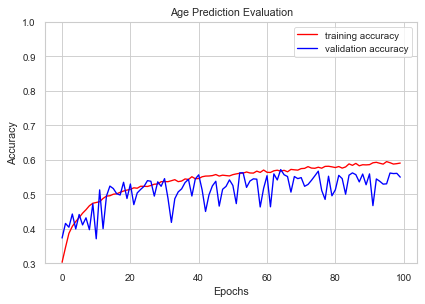

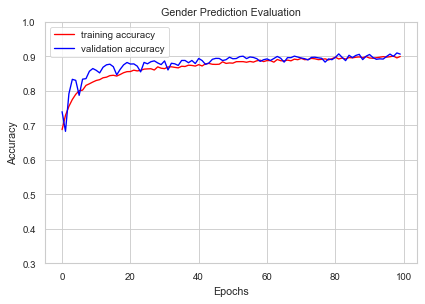

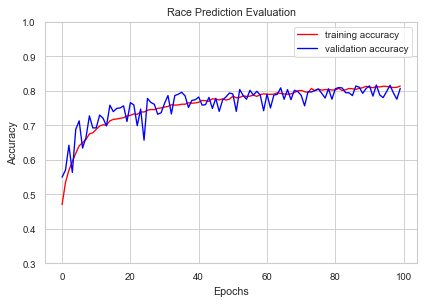

With model1: 
The accuracy for AGE in the test set is 56.65%
The accuracy for GENDER in the test set is 90.95%
The accuracy for RACE in the test set is 79.34%
Total loss is 1.90
47/47 [==============================] - 3s 68ms/step


,precision,recall,f1-score,support
0 <= age < 6,0.978873,0.896774,0.936027,155.000000
6 <= age < 12,0.568966,0.647059,0.605505,51.000000
12 <= age < 25,0.439759,0.646018,0.523297,226.000000
25 <= age < 35,0.575139,0.643154,0.607248,482.000000
35 <= age < 45,0.394737,0.234375,0.294118,192.000000
45 <= age < 60,0.619469,0.325581,0.426829,215.000000
60 <= age < 80,0.540146,0.592000,0.564885,125.000000
age >= 80,0.478261,0.628571,0.543210,35.000000
accuracy,0.566509,0.566509,0.566509,0.566509
macro avg,0.574419,0.576692,0.562640,1481.000000


,precision,recall,f1-score,support
male,0.933244,0.892720,0.912533,783.000000
female,0.885246,0.928367,0.906294,698.000000
accuracy,0.909521,0.909521,0.909521,0.909521
macro avg,0.909245,0.910544,0.909413,1481.000000
weighted avg,0.910623,0.909521,0.909592,1481.000000


,precision,recall,f1-score,support
white,0.848000,0.850722,0.849359,623.000000
black,0.770898,0.886121,0.824503,281.000000
asian,0.909605,0.718750,0.802993,224.000000
indian,0.709898,0.787879,0.746858,264.000000
others,0.428571,0.303371,0.355263,89.000000
accuracy,0.793383,0.793383,0.793383,0.793383
macro avg,0.733394,0.709369,0.715795,1481.000000
weighted avg,0.792865,0.793383,0.789666,1481.000000


In [260]:
evaluate_model(model, history1, "model1")

### 4.2 Model2

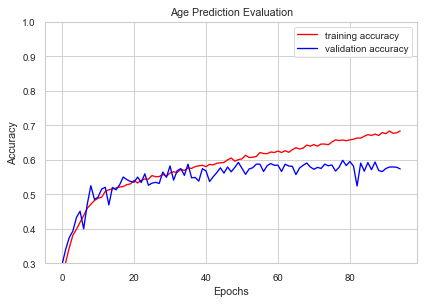

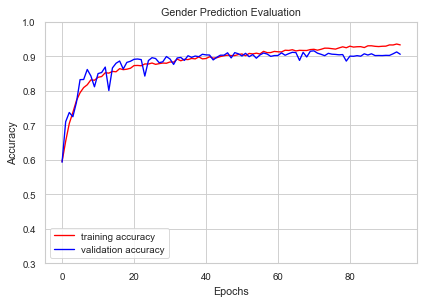

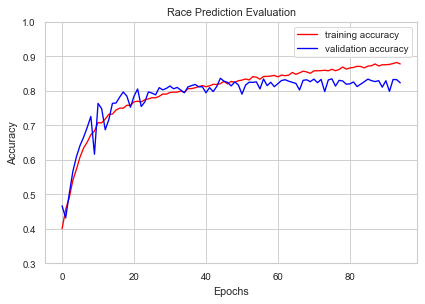

With model2: 
The accuracy for AGE in the test set is 59.28%
The accuracy for GENDER in the test set is 91.42%
The accuracy for RACE in the test set is 81.16%
Total loss is 1.74
47/47 [==============================] - 32s 682ms/step


,precision,recall,f1-score,support
0 <= age < 6,0.992481,0.851613,0.916667,155.000000
6 <= age < 12,0.476923,0.607843,0.534483,51.000000
12 <= age < 25,0.571429,0.495575,0.530806,226.000000
25 <= age < 35,0.622744,0.715768,0.666023,482.000000
35 <= age < 45,0.441441,0.255208,0.323432,192.000000
45 <= age < 60,0.500000,0.497674,0.498834,215.000000
60 <= age < 80,0.487179,0.608000,0.540925,125.000000
age >= 80,0.500000,0.742857,0.597701,35.000000
accuracy,0.592843,0.592843,0.592843,0.592843
macro avg,0.574025,0.596817,0.576109,1481.000000


,precision,recall,f1-score,support
male,0.917303,0.920817,0.919057,783.000000
female,0.910791,0.906877,0.908830,698.000000
accuracy,0.914247,0.914247,0.914247,0.914247
macro avg,0.914047,0.913847,0.913943,1481.000000
weighted avg,0.914234,0.914247,0.914237,1481.000000


,precision,recall,f1-score,support
white,0.849170,0.903692,0.875583,623.000000
black,0.833898,0.875445,0.854167,281.000000
asian,0.845455,0.830357,0.837838,224.000000
indian,0.710714,0.753788,0.731618,264.000000
others,0.347826,0.089888,0.142857,89.000000
accuracy,0.811614,0.811614,0.811614,0.811614
macro avg,0.717413,0.690634,0.688412,1481.000000
weighted avg,0.790902,0.811614,0.796115,1481.000000


In [261]:
evaluate_model(model2, history2, "model2")

### 4.3 Model3

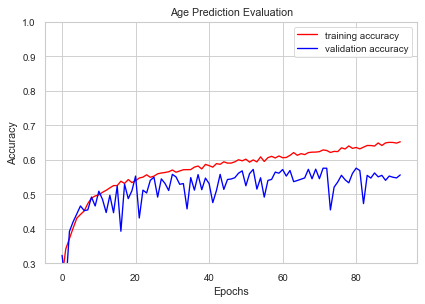

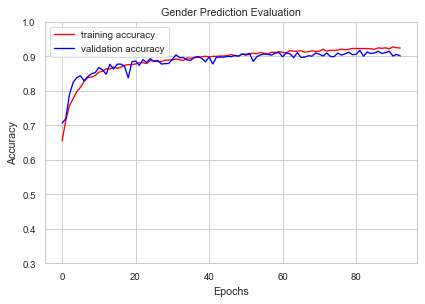

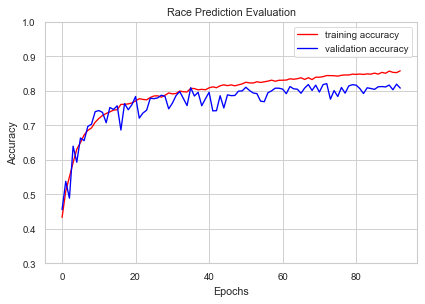

With model3: 
The accuracy for AGE in the test set is 59.49%
The accuracy for GENDER in the test set is 91.22%
The accuracy for RACE in the test set is 81.23%
Total loss is 1.72
47/47 [==============================] - 14s 302ms/step


,precision,recall,f1-score,support
0 <= age < 6,0.928105,0.916129,0.922078,155.000000
6 <= age < 12,0.543860,0.607843,0.574074,51.000000
12 <= age < 25,0.591716,0.442478,0.506329,226.000000
25 <= age < 35,0.610915,0.719917,0.660952,482.000000
35 <= age < 45,0.378641,0.203125,0.264407,192.000000
45 <= age < 60,0.515873,0.604651,0.556745,215.000000
60 <= age < 80,0.536232,0.592000,0.562738,125.000000
age >= 80,0.439024,0.514286,0.473684,35.000000
accuracy,0.594868,0.594868,0.594868,0.594868
macro avg,0.568046,0.575054,0.565126,1481.000000


,precision,recall,f1-score,support
male,0.929041,0.902937,0.915803,783.000000
female,0.894444,0.922636,0.908322,698.000000
accuracy,0.912221,0.912221,0.912221,0.912221
macro avg,0.911743,0.912787,0.912062,1481.000000
weighted avg,0.912735,0.912221,0.912277,1481.000000


,precision,recall,f1-score,support
white,0.871674,0.894061,0.882726,623.000000
black,0.833333,0.871886,0.852174,281.000000
asian,0.850000,0.834821,0.842342,224.000000
indian,0.730337,0.738636,0.734463,264.000000
others,0.311475,0.213483,0.253333,89.000000
accuracy,0.812289,0.812289,0.812289,0.812289
macro avg,0.719364,0.710578,0.713008,1481.000000
weighted avg,0.802262,0.812289,0.806569,1481.000000


In [263]:
evaluate_model(model3, history3, "model3")

## 5 Output Visualization

In this part I will visualize the predictions of the model with best performance (model 3).

### 5.1 Prepare Data

In [222]:
pred_age, pred_gender, pred_race = model5.predict(x_test)

In [224]:
pred_age = np.argmax(pred_age, axis=1)
pred_gender = np.argmax(pred_gender, axis=1)
pred_race = np.argmax(pred_race, axis = 1)

images_show = images[n1:n2]
true_age_list = ages[n1:n2]
true_gender_list = genders[n1:n2]
true_race_list = races[n1:n2]


def age_diaplay_class(age):
    if age == 0:
        return "0-5"
    elif age == 1:
        return "6-11"
    elif age == 2:
        return "12-24"
    elif age == 3:
        return "25-34"
    elif age == 4:
        return "35-44"
    elif age == 5:
        return "45-59"
    elif age == 6:
        return "60-79"
    else: 
        return "80+"
    
def age_diaplay_class2(age):
    if age == "class1":
        return "0-5"
    elif age == "class2":
        return "6-11"
    elif age == "class3":
        return "12-24"
    elif age == "class4":
        return "25-34"
    elif age == "class5":
        return "35-44"
    elif age == "class6":
        return "45-59"
    elif age == "class7":
        return "60-79"
    else: 
        return "80+"

for i in range(len(true_age_list)):
    temp = true_age_list[i]
    true_age_list[i] = age_diaplay_class2(temp)

pred_age_list = pred_age.tolist()
for i in range(len(pred_age_list)):
    temp = pred_age_list[i]
    pred_age_list[i] = age_diaplay_class(temp)

# for i in range(len(true_age_list)):
#     temp = true_age_list[i]
#     true_age_list[i] = age_group(temp)

pred_gender_list = pred_gender.tolist()
for i in range(len(pred_gender_list)):
    temp = pred_gender_list[i]
    pred_gender_list[i] = gender_group(temp)

pred_race_list = pred_race.tolist()
for i in range(len(pred_race_list)):
    temp = pred_race_list[i]
    pred_race_list[i] = race_group(temp)


### 5.2 Visualize Result

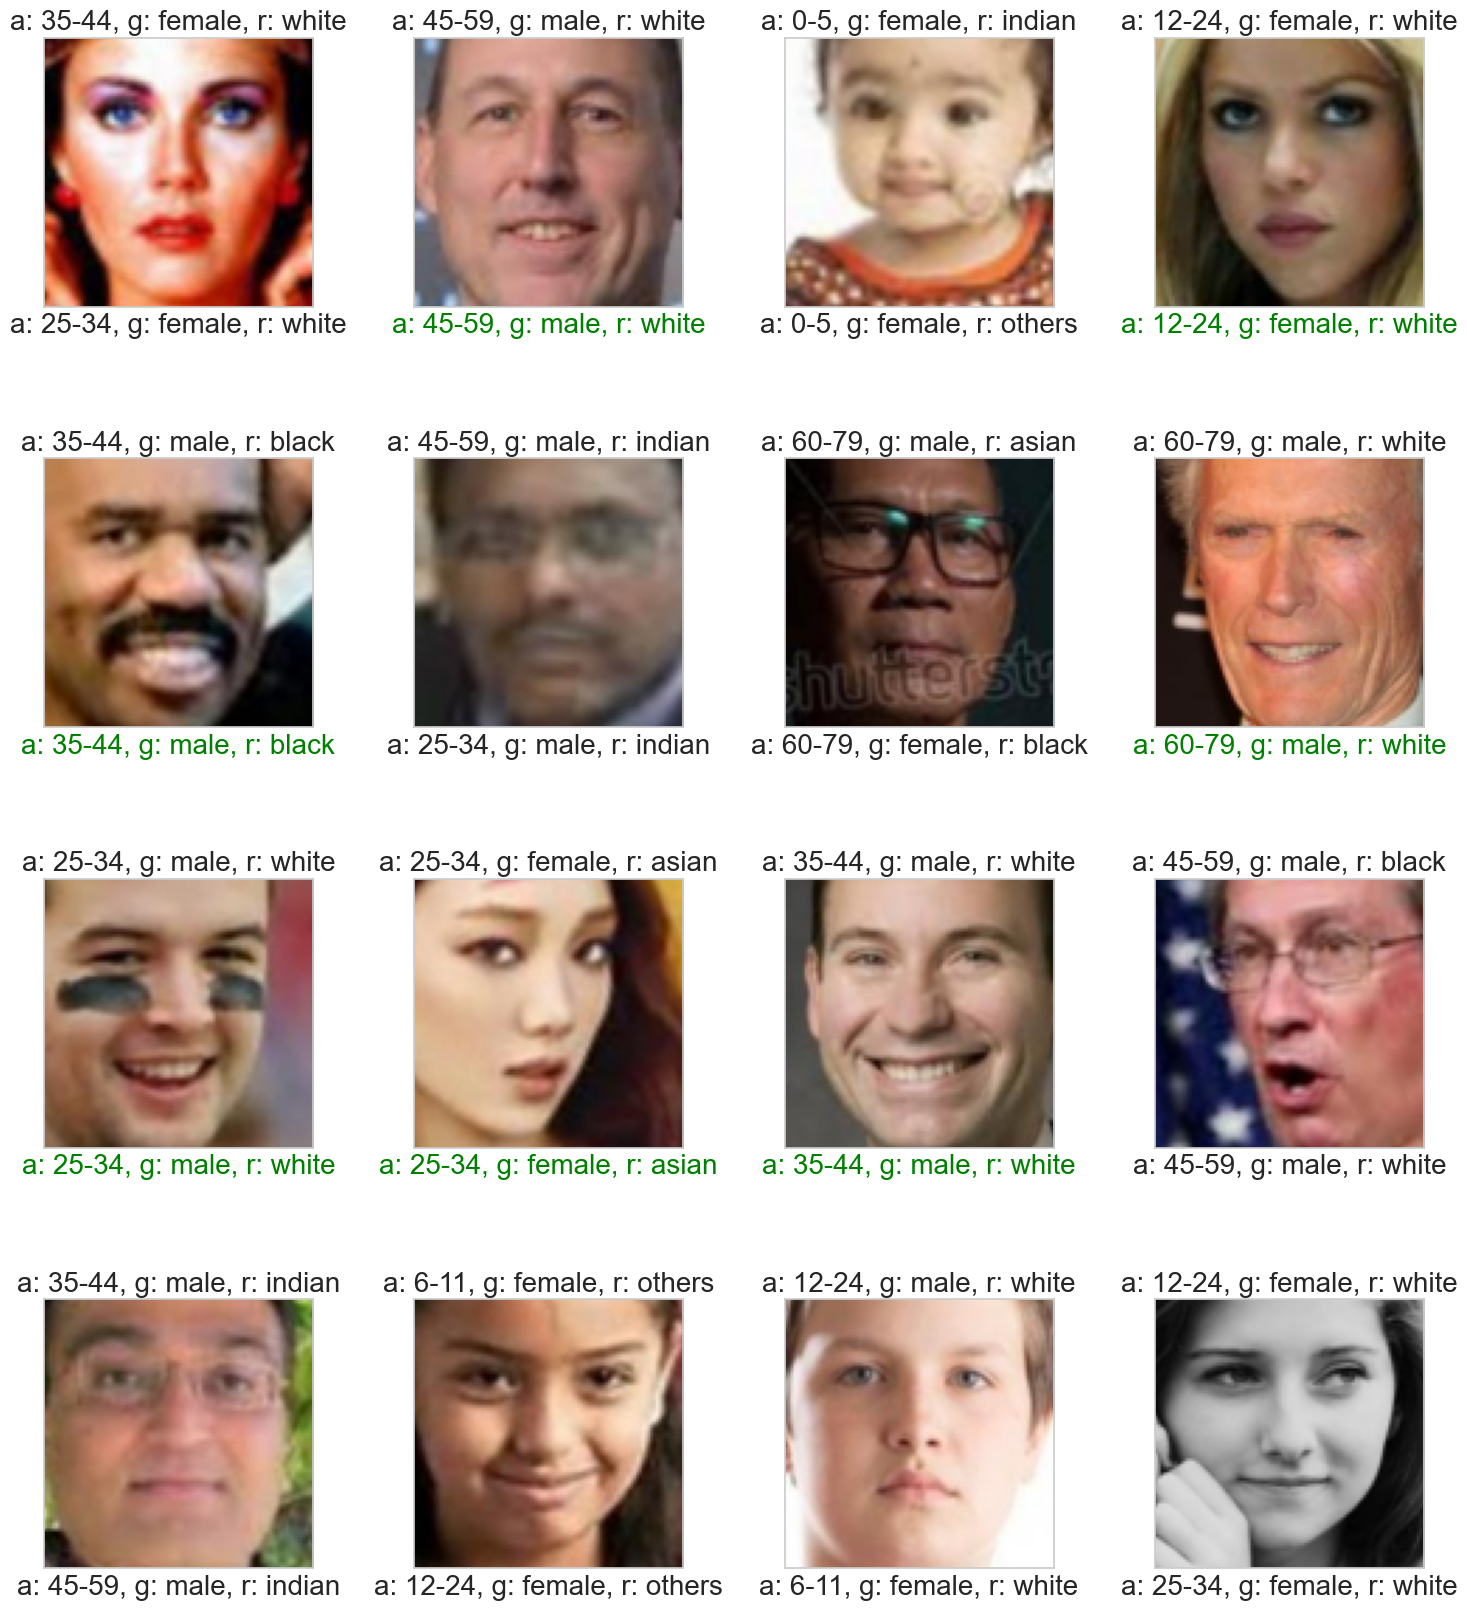

In [241]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images_show[img_idx])
    
    cur_age_pred = pred_age_list[img_idx]
    cur_age_true = true_age_list[img_idx]
    
    cur_gender_pred = pred_gender_list[img_idx]
    cur_gender_true = true_gender_list[img_idx]
    
    cur_race_pred = pred_race_list[img_idx]
    cur_race_true = true_race_list[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and cur_age_pred == cur_age_true:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and cur_age_pred != cur_age_true:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('a: {}, g: {}, r: {}'.format(pred_age_list[img_idx],
                            pred_gender_list[img_idx],
                               pred_race_list[img_idx]), fontsize = 20)
    
    ax.set_title('a: {}, g: {}, r: {}'.format(true_age_list[img_idx],
                            true_gender_list[img_idx],
                               true_race_list[img_idx]), fontsize = 20)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig("pred1.png", dpi = 300, bbox_inches='tight')